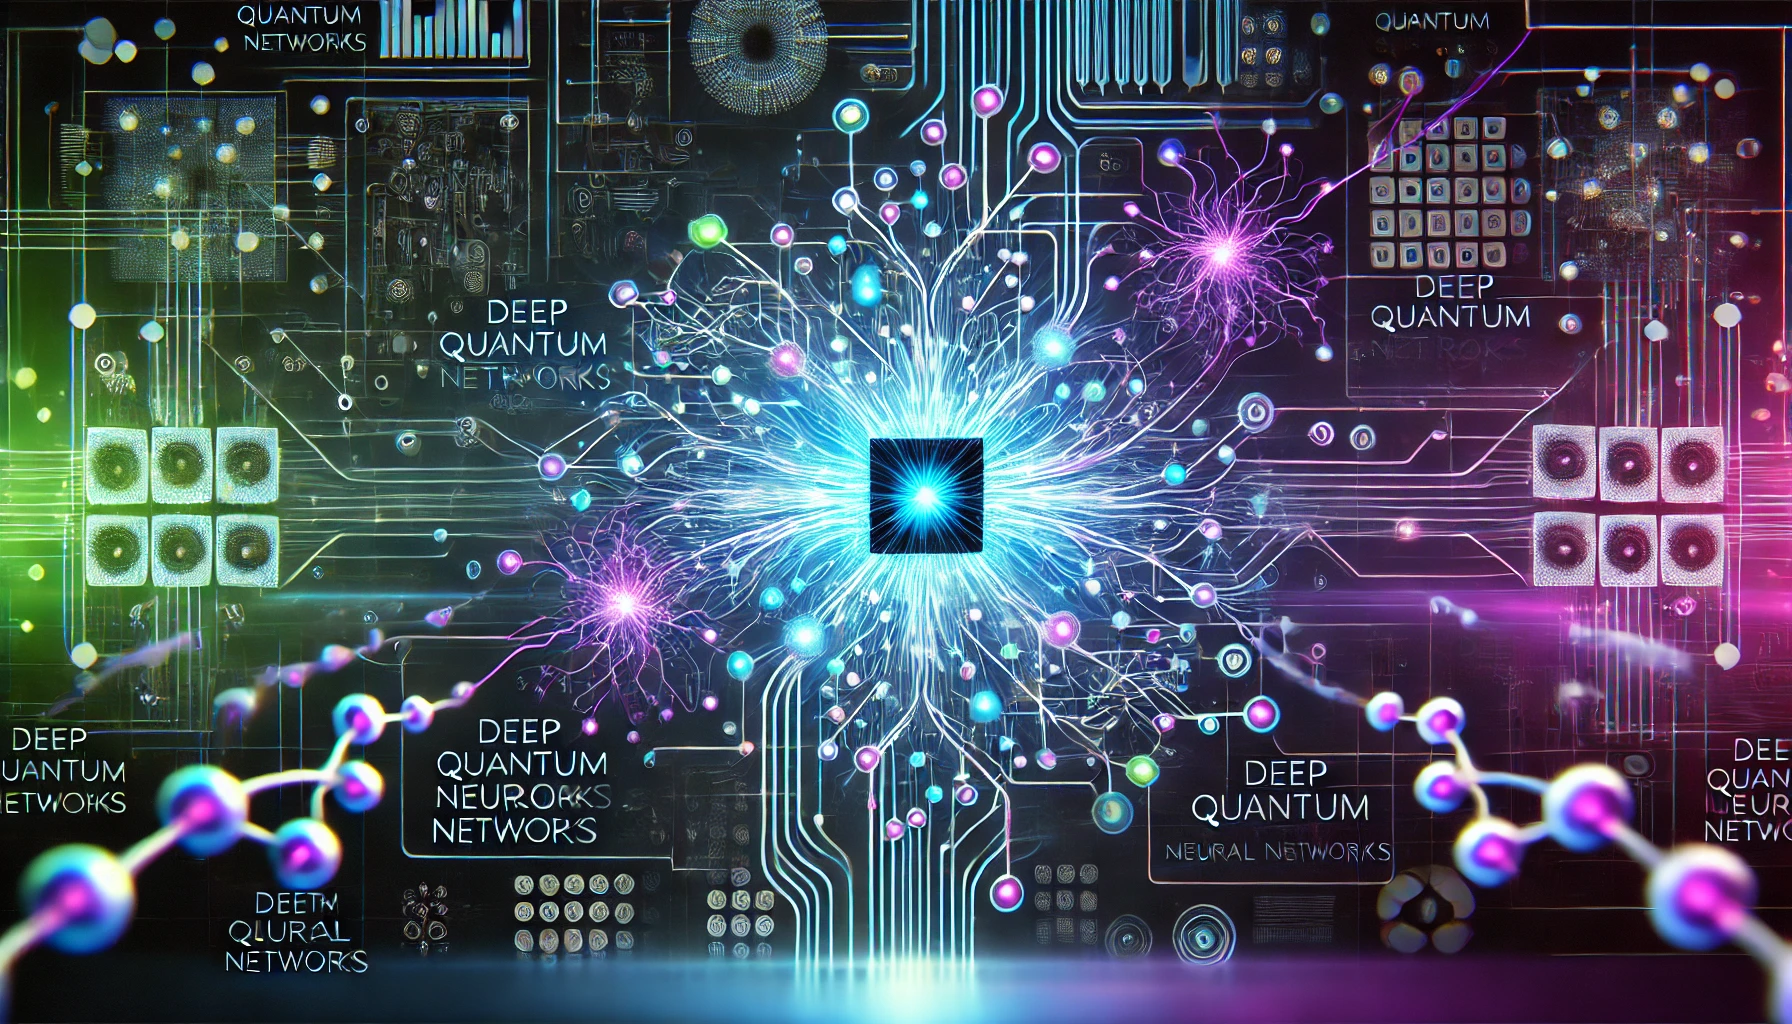

# Building Basic Quantum Circuits

## Package-imports, universal definitions and remarks

### Importing Packages

In [ ]:
! pip install qutip

In [ ]:
# math related packages
import scipy as sc
import qutip as qt
# further packages
from time import time
from random import sample
import matplotlib.pyplot as plt

#### Declaration of qubit kets and density matrices

In [ ]:
# ket states
qubit0 = qt.basis(2,0)
qubit1 = qt.basis(2,1)
# density matrices
qubit0mat = qubit0 * qubit0.dag() # it is also possible to use ket2dm(qubit0)
qubit1mat = qubit1 * qubit1.dag() # it is also possible to use ket2dm(qubit1)

### Data conventions

The parameter for the __QNN-Architecture__ $\text{qnnArch}$ describes the structure of a quantum neural network. It is expected to be a 1-dimensional list of natural numbers that which refer to the number of perceptrons in the corresponding layer. E.g. a 2-3-2 network would be given by $\text{qnnArch = [2, 3, 2]}$


The __networks unitaries__ are saved in a 2-dimensional list of Qobjs in a tensored state like

$$\text{unitaries}  = \big[ [\, ],[U_1^1, \dots, U_{m_1}^1], \dots, [U_1^l, \dots, U_{m_l}^l], \dots, [U_1^{out}, \dots, U_{m_{out}}^{out}]\big]$$

$$\text{unitaries[l][j]} = U_{j+1}^l$$

Note that for the perceptron unitaries __no zero-indexing__ is used, since the project was originally initialized in Mathematica.

The __training data__ is saved in $\text{trainingData}$, a 2-dimensional list, where every inner list has exactly two elements like

$$trainingData = \big[ [\text{state}_1,\, \text{unitary} \cdot \text{state}_1], \dots , [\text{state}_N,\, \text{unitary} \cdot \text{state}_N] \big]$$

where $\text{unitary}$ is the __targeted network unitary__. We exemplary build this data with a random unitary. However, in the use case this data would be given.

## Helper functions for the QNN-Code

### Partial Trace

The $\text{partialTrace}$ functions assume to be given a quantum object (qutip.Qobj) $\text{obj}$ that is the tensor product of m factors $\{0, 1, \dots, m-1\}$. The functions then calculate and return the __partial trace__ as follows:

$\text{partialTraceRem}$ traces out the factors $$\text{rem} \subsetneq \{0, \dots, m-1\}$$

$\text{partialTraceKeep}$ traces out the factors $$\big( \{0, \dots, m-1\} \setminus \text{keep}\big) \subsetneq \{0, \dots, m-1\}$$

No duplicates in $\text{rem}$ allowed. No values $\geq m$ in $\text{rem}$ or $\text{keep}$ allowed.

In [ ]:
def partialTraceKeep(obj, keep): # generalisation of ptrace(), partial trace via "to-keep" list
    # return partial trace:
    res = obj;
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;

def partialTraceRem(obj, rem): # partial trace via "to-remove" list
    # prepare keep list
    rem.sort(reverse=True)
    keep = list(range(len(obj.dims[0])))
    for x in rem:
        keep.pop(x)
    res = obj;
    # return partial trace:
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;


### Basis swap

$\text{swappedOp}$ assumes to be given a quantum object (qutip.Qobj) $\text{obj}$ that is the tensor product of $m$ factors. For

$$\text{obj} = A_0 \otimes \dots \otimes A_i \otimes \dots \otimes A_j \otimes \dots A_{m-1}$$

the function returns

$$A_0 \otimes \dots \otimes A_j \otimes \dots \otimes A_i \otimes \dots A_{m-1}$$

where the factors $i, j \in \{1, \dots, m \}$ are __swapped__.

In [ ]:
def swappedOp(obj, i, j):
    if i==j: return obj
    numberOfQubits = len(obj.dims[0])
    permute = list(range(numberOfQubits))
    permute[i], permute[j] = permute[j], permute[i]
    return obj.permute(permute)

### Further functions

$\text{tensoredId}$ returns $\underbrace{\mathbb{1}_2 \otimes \dots \otimes \mathbb{1}_2}_{N \text{-times}}$

$\text{tensoredQubit0}$ returns $\ket{0 \dots 0}_N \bra{0 \dots 0}$

In [ ]:
def tensoredId(N):
    #Make Identity matrix
    res = qt.qeye(2**N)
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

def tensoredQubit0(N):
    #Make Qubit matrix
    res = qt.fock(2**N).proj() #for some reason ran faster than fock_dm(2**N) in tests
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

$\text{unitariesCopy}$ assumes to be given $\text{unitaries}$ as usual and returns a __deep copy__ of it, meaning a new 2-dimensional list where every element is a copy of the element at the same position in the given 2d-list.

In [ ]:
def unitariesCopy(unitaries): # deep copyof a list of unitaries
    newUnitaries = []
    for layer in unitaries:
        newLayer = []
        for unitary in layer:
            newLayer.append(unitary.copy())
        newUnitaries.append(newLayer)
    return newUnitaries

## Random generation of unitaries, training data and networks

### Generation of random unitaries:

$\text{randomQubitUnitary}$ return a unitary $2^{\text{numQubits}} \times 2^{\text{numQubits}}$-matrix as a quantum object (qutip.Qobj) that is the tensor product of $\text{numQubits}$ factors. Before orthogonalization, it's elements are randomly picked out of a normal distribution.

In [ ]:
def randomQubitUnitary(numQubits): # alternatively, use functions rand_unitary and rand_unitary_haar
    dim = 2**numQubits
    #Make unitary matrix
    res = sc.random.normal(size=(dim,dim)) + 1j * sc.random.normal(size=(dim,dim))
    res = sc.linalg.orth(res)
    res = qt.Qobj(res)
    #Make dims list
    dims = [2 for i in range(numQubits)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

### Generation of random training data

$\text{randomQubitState}$ return a unitary $2^{\text{numQubits}}$-vector as a quantum object (qutip.Qobj) that is the tensor product of $\text{numQubits}$ factors. Before normalization, it's elements are randomly picked out of a normal distribution.

$\text{randomTrainingData}$ assumes to be given a unitary quantom object (qutip.Qobj) $\text{unitary}$ that is the tensor product of m factors and returns a list of $N$ training pairs like

$$trainingData = \big[ [\text{state}_1,\, \text{unitary} \cdot \text{state}_1], \dots , [\text{state}_N,\, \text{unitary} \cdot \text{state}_N] \big]$$

In [ ]:
def randomQubitState(numQubits): # alternatively, use functions rand_ket and rand_ket_haar
    dim = 2**numQubits
    #Make normalized state
    res = sc.random.normal(size=(dim,1)) + 1j * sc.random.normal(size=(dim,1))
    res = (1/sc.linalg.norm(res)) * res
    res = qt.Qobj(res)
    #Make dims list
    dims1 = [2 for i in range(numQubits)]
    dims2 = [1 for i in range(numQubits)]
    dims = [dims1, dims2]
    res.dims = dims
    #Return
    return res

def randomTrainingData(unitary, N): # generating training data based on a unitary
    numQubits = len(unitary.dims[0])
    trainingData=[]
    #Create training data pairs
    for i in range(N):
        t = randomQubitState(numQubits)
        ut = unitary*t
        trainingData.append([t,ut])
    #Return
    return trainingData

### Note regarding Qobj.dims

__Quantum objects in the QuTiP package__ have two properties regarding their sizes: $\text{shape}$ and $\text{dims}$. While $\text{shape}$ denotes the "dimensions of the underlying data matrix", $\text{dims}$ is a "list keeping track of shapes for individual components of a multipartite system" (quoted from the $\text{qutip}$-documentation). The qutip package will only allow operations such as the multiplication of two $\text{Qobj}$ objects $A$ and $B$, if not only their $\text{shape}$s, but also their $\text{dims}$ are compatible. Essentially all $\text{Qobj}$ objects in this work are representing operators or states in an multipartite system of $n$ qubits. As we create such objects with the desired $\text{shape}$, we have to ensure that their $\text{dims}$ are reflective of that, which is why we manually overwrite them to meet this criteria.

### Generation of an initial network

The function $\text{randomNetwork}$ eats a valid QNN architecture $\text{qnnArch}$ and a number of training data pairs, and returns a 4-tuple that __completely describes a trainable quantum-neural-network__ like

$$\big(\text{qnnArch}, \ \text{unitaries} , \ \text{trainingData}, \ \text{networkUnitary} \big)$$

where $\text{networkUnitary}$ being the targeted network unitary (with which the training data was created).

In [ ]:
def randomNetwork(qnnArch, numTrainingPairs):
    assert qnnArch[0]==qnnArch[-1], "Not a valid QNN-Architecture."

    #Create the targeted network unitary and corresponding training data
    networkUnitary = randomQubitUnitary(qnnArch[-1])
    networkTrainingData = randomTrainingData(networkUnitary, numTrainingPairs)

    #Create the initial random perceptron unitaries for the network
    networkUnitaries = [[]]
    for l in range(1, len(qnnArch)):
        numInputQubits = qnnArch[l-1]
        numOutputQubits = qnnArch[l]

        networkUnitaries.append([])
        for j in range(numOutputQubits):
            unitary = randomQubitUnitary(numInputQubits+1)
            if numOutputQubits-1 != 0:
                unitary = qt.tensor(randomQubitUnitary(numInputQubits+1), tensoredId(numOutputQubits-1))
                unitary = swappedOp(unitary, numInputQubits, numInputQubits + j)
            networkUnitaries[l].append(unitary)

    #Return
    return (qnnArch, networkUnitaries, networkTrainingData, networkUnitary)

## QNN-Code

### Cost Function

$\text{costFunction}$ assumes to be given $\text{trainingData}$ and $\text{outputStates}$ so that

$$\text{trainingData[x][1]} = \ket{\phi_x^{out}}$$

$$\text{outputStates[x]} = \rho_x^{out}(s)$$

and computes the cost function:

$$C(s) = \frac{1}{N} \sum_{x = 1}^N \bra{\phi_x^{out}} \rho_x^{out}(s) \ket{\phi_x^{out}}$$

In [ ]:
def costFunction(trainingData, outputStates):
    costSum = 0
    for i in range(len(trainingData)):
        costSum += trainingData[i][1].dag() * outputStates[i] * trainingData[i][1]
    return costSum.tr()/len(trainingData)

### Layer-Channel & Adjoint-Layer-Channel

$\text{makeLayerChannel}$ builds

\begin{align}
\\
\mathcal{E}_s^l(X^{l-1}) & = \text{tr}_{l-1}\bigg( U^l(s) \ \big( X^{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U^l(s)^{\dagger} \bigg) \\
& = \text{tr}_{l-1}\bigg( U_{m_l}^l(s) \dots U_1^l(s) \ \big( X^{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U_1^l(s)^{\dagger} \dots U_{m_l}^l(s)^{\dagger} \bigg)
\\
\end{align}

and hence describes the __feed-forward process__ for $\text{inputState} = X^{l-1}$, given the QNN architecture, current QNN unitaries and layer number $l$.

In [ ]:
def makeLayerChannel(qnnArch, unitaries, l, inputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Tensor input state
    state = qt.tensor(inputState, tensoredQubit0(numOutputQubits))

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni

    #Multiply and tensor out input state
    return partialTraceRem(layerUni * state * layerUni.dag(), list(range(numInputQubits)))

Similarly $\text{makeAdjointLayerChannel}$ builds

\begin{align}
\\
\mathcal{F}_s^l(X^{l}) & = \text{tr}_{l}\bigg( \big( \mathbb{1}_{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U^{l}(s)^{\dagger} \ \big( \mathbb{1}_{l-1} \otimes X^l \big) \ U^l(s) \bigg) \\
& = \text{tr}_{l}\bigg( \big( \mathbb{1}_{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U_1^l(s)^{\dagger} \dots U_{m_l}^l(s)^{\dagger} \ \big( \mathbb{1}_{l-1} \otimes X^l \big) \ U_{m_l}^l(s) \dots U_1^l(s) \bigg)
\\
\end{align}
and describes the __back-propagation process__.

In [ ]:
def makeAdjointLayerChannel(qnnArch, unitaries, l, outputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Prepare needed states
    inputId = tensoredId(numInputQubits)
    state1 = qt.tensor(inputId, tensoredQubit0(numOutputQubits))
    state2 = qt.tensor(inputId, outputState)

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni

    #Multiply and tensor out output state
    return partialTraceKeep(state1 * layerUni.dag() * state2 * layerUni, list(range(numInputQubits)) )

### Feedforward

$\text{feedforward}$ assumes to be given $\text{qnnArch},\, \text{unitaries}$ and $\text{trainingData}$, carries out the feedforward process:

For each element $\big[\, \ket{\phi_x^{in}},\, \ket{\phi_x^{out}} \big]$ in $\text{trainingData}$ do:

- Calculate the network input $\rho_x^{in} = \ket{\phi_x^{in}} \bra{\phi_x^{in}}$

- For every layer $l$ in $\text{qnnArch}$ do:

    - Apply the layer channel $\xi_s^l$ to the output of the previous layer $l-1$

    - Store the result $\rho_x^l(s)$

In [ ]:
def feedforward(qnnArch, unitaries, trainingData):
    storedStates = []
    for x in range(len(trainingData)):
        currentState = trainingData[x][0] * trainingData[x][0].dag()
        layerwiseList = [currentState]
        for l in range(1, len(qnnArch)):
            currentState = makeLayerChannel(qnnArch, unitaries, l, currentState)
            layerwiseList.append(currentState)
        storedStates.append(layerwiseList)
    return storedStates

### Update matrix

$\text{makeUpdateMatrix}$ assumes to be given $\text{qnnArch},\, \text{unitaries},\, \text{trainingData}$ and $\text{storedStates}$ as usual, as well as $\lambda,\, \epsilon \in \mathbb{R}$, and calculates

$$\text{exp}\big( i \, \epsilon \, K_j^l(s) \big)$$

with

$$K_j^l(s) = \frac{2^{n_{a_1, \dots, \beta}} \, i}{2 N \lambda} \sum_x \text{tr}_\text{rest} M_j^l(s)$$

with

$$M_j^l(s) = \big[A_j^l(s), B_j^l(s) \big]$$

with

\begin{align}
A_j^l(s) & = U_j^l(s) \dots U_1^l(s) \, \big( \rho_x^{l-1}(s) \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \, U_1^l(s)^{\dagger} \dots U_j^l(s)^{\dagger} \\
\\
B_j^l(s) & = U_{j+1}^l(s)^{\dagger} \dots U_{m_l}^l(s)^{\dagger} \, \big( \mathbb{1}_l \otimes \sigma_x^l(s) \big) \, U_{m_l}^l(s) \dots U_{j+1}^l(s)
\end{align}

with

$$\sigma_x^l(s) = \mathcal{F}_s^{l+1} \big( \dots \mathcal{F}_s^{out} \big( \ket{\phi_x^{out}} \bra{\phi_x^{out}} \big) \dots \big).$$

Here the $\text{updateMatrixFirstPart}$ calculates $A_j^l(s)$, $\text{updateMatrixSecondPart}$ calculates $B_j^l(s)$.

$\text{makeUpdateMatrixTensored}$ tensors the result to identities in a way, such that it can be applied to the already tensored perceptron unitaries.
__Note that the backpropagation process is hidden in the part $B_j^l(s)$ of calculating the update matrix.__

In [ ]:
def makeUpdateMatrix(qnnArch, unitaries, trainingData, storedStates, lda, ep, l, j):
    numInputQubits = qnnArch[l-1]

    #Calculate the sum:
    summ = 0
    for x in range(len(trainingData)):
        #Calculate the commutator
        firstPart = updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x)
        secondPart = updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x)
        mat = qt.commutator(firstPart, secondPart)

        #Trace out the rest
        keep = list(range(numInputQubits))
        keep.append(numInputQubits + j)
        mat = partialTraceKeep(mat, keep)

        #Add to sum
        summ = summ + mat

    #Calculate the update matrix from the sum
    summ = (-ep * (2**numInputQubits)/(lda*len(trainingData))) * summ
    return summ.expm()


def updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Tensor input state
    state = qt.tensor(storedStates[x][l-1], tensoredQubit0(numOutputQubits))

    #Calculate needed product unitary
    productUni = unitaries[l][0]
    for i in range(1, j+1):
        productUni = unitaries[l][i] * productUni

    #Multiply
    return productUni * state * productUni.dag()


def updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Calculate sigma state
    state = trainingData[x][1] * trainingData[x][1].dag()
    for i in range(len(qnnArch)-1,l,-1):
        state = makeAdjointLayerChannel(qnnArch, unitaries, i, state)
    #Tensor sigma state
    state = qt.tensor(tensoredId(numInputQubits), state)

    #Calculate needed product unitary
    productUni = tensoredId(numInputQubits + numOutputQubits)
    for i in range(j+1, numOutputQubits):
        productUni = unitaries[l][i] * productUni

    #Multiply
    return productUni.dag() * state * productUni


def makeUpdateMatrixTensored(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    res = makeUpdateMatrix(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j)
    if numOutputQubits-1 != 0:
        res = qt.tensor(res, tensoredId(numOutputQubits-1))
    return swappedOp(res, numInputQubits, numInputQubits + j)

### Training of the Quantum Neural Network

$\text{qnnTraining}$ assumes to be given $\text{qnnArch},\, \text{initialUnitaries}$ and $\text{trainingData}$ as usual, as well as parameters $\lambda,\, \epsilon \in \mathbb{R}$ and $\text{trainingRounds} \in \mathbb{N}$, and __trains the given quantum neural network__:

In [ ]:
def qnnTraining(qnnArch, initialUnitaries, trainingData, lda, ep, trainingRounds, alert=0):

    ### FEEDFORWARD
    #Feedforward for given unitaries
    s = 0
    currentUnitaries = initialUnitaries
    storedStates = feedforward(qnnArch, currentUnitaries, trainingData)

    #Cost calculation for given unitaries
    outputStates = []
    for k in range(len(storedStates)):
        outputStates.append(storedStates[k][-1])
    plotlist = [[s], [costFunction(trainingData, outputStates)]]

    #Optional
    runtime = time()

    #Training of the Quantum Neural Network
    for k in range(trainingRounds):
        if alert>0 and k%alert==0: print("In training round "+str(k))

        ### UPDATING
        newUnitaries = unitariesCopy(currentUnitaries)

        #Loop over layers:
        for l in range(1, len(qnnArch)):
            numInputQubits = qnnArch[l-1]
            numOutputQubits = qnnArch[l]

            #Loop over perceptrons
            for j in range(numOutputQubits):
                newUnitaries[l][j] = (makeUpdateMatrixTensored(qnnArch,currentUnitaries,trainingData,storedStates,lda,ep,l,j)* currentUnitaries[l][j])

        ### FEEDFORWARD
        #Feedforward for given unitaries
        s = s + ep
        currentUnitaries = newUnitaries
        storedStates = feedforward(qnnArch, currentUnitaries, trainingData)

        #Cost calculation for given unitaries
        outputStates = []
        for m in range(len(storedStates)):
            outputStates.append(storedStates[m][-1])
        plotlist[0].append(s)
        plotlist[1].append(costFunction(trainingData, outputStates))

    #Optional
    runtime = time() - runtime
    print("Trained "+str(trainingRounds)+" rounds for a "+str(qnnArch)+" network and "+str(len(trainingData))+" training pairs in "+str(round(runtime, 2))+" seconds")

    #Return
    return [plotlist, currentUnitaries]

## Helper-functions for Tests and Applications

$\text{boundRand}$ gives a formula for the estimate of the cost function, where $D$ is the dimension of the qudit that the network unitary is acting on and $N$ is the number of available training pairs of which the first $n < D$ are chosen for training:

$$C \sim \frac{n}{N} + \frac{N - n}{N \cdot D \cdot (D+1)} \big(D + \text{min}\{n^2 + 1,\, D^2\} \big)$$

In [ ]:
def boundRand(D, N, n):
    return (n/N) + (N-n)/(N*D*(D+1)) * (D + min(n**2+1, D**2))

$\text{subsetTrainingAvg}$ is given the parameters $\text{qnnArch},\, \text{initialUnitaries},\, \text{trainingData},\, \lambda,\, \epsilon$ and $\text{trainingRounds}$ just like $\text{qnnTraining}$. Additionally it recieves  $n, \text{iterations} \in \mathbb{N}$.

$\text{subsetTrainingAvg}$ then does the following $\text{iterations}$-times:

- Choose a subset of $\text{trainingData}$ of size $n$

- Train the given network with said subset

- Calculate the cost function of the resulting network over the whole set of $\text{trainingData}$ and store it

$\text{subsetTrainingAvg}$ ultimately returns the cost averaged over all $\text{iterations}$ results.

In [ ]:
def subsetTrainingAvg(qnnArch, initialUnitaries, trainingData, lda, ep, trainingRounds, iterations, n, alertIt=0):
    costpoints = []

    for i in range(iterations):
        if alertIt>0 and i%alertIt==0: print("n="+str(n)+", i="+str(i))

        #Prepare subset for training
        trainingSubset = sample(trainingData, n)

        #Train with the subset
        learnedUnitaries = qnnTraining(qnnArch, initialUnitaries, trainingSubset, lda, ep, trainingRounds)[1]
        storedStates = feedforward(qnnArch, learnedUnitaries, trainingData)
        outputStates = []
        for k in range(len(storedStates)):
            outputStates.append(storedStates[k][-1])

        #Calculate cost with all training data
        costpoints.append(costFunction(trainingData, outputStates))

    return sum(costpoints)/len(costpoints)

$\text{noisyDataTraining}$ is given the parameters $\text{qnnArch},\, \text{initialUnitaries},\, \lambda,\, \epsilon$ and $\text{trainingRounds}$ just like $\text{qnnTraining}$. Additionally it recieves  $\text{numData}, \text{stepSize} \in \mathbb{N}$ and $\text{trainingData}, \text{noisyData}$.

$\text{noisyDataTraining}$ then does the following ***for i=0; i<numData; i+=stepSize:***

- Create a list $\text{testData}$ by combining a random sample of $\text{trainingData}$ of size $\text{numData}-i$ and a random sample of $\text{noisyData}$ of size $i$

- Train the given network with said $\text{testData}$

- Calculate the cost function of the resulting network over the whole set of $\text{trainingData}$ and store it

$\text{noisyDataTraining}$ ultimately returns the list of costs for all $i$ like

\begin{align}
\big[ & [0, \dots, i, \dots]\\
& [\text{Cost}_0, \dots, \text{Cost}_i, \dots] \big]
\end{align}

In [ ]:
def noisyDataTraining(qnnArch, initialUnitaries, trainingData, noisyData, lda, ep, trainingRounds, numData, stepSize, alertP=0):
    noisyDataPlot = [[], []]

    i = 0
    while i <= numData:
        if alertP>0: print("Currently at "+str(i/numData)+"% noisy data.")

        #Prepare mixed data for traing
        testData1 = sample(trainingData, numData - i)
        testData2 = sample(noisyData, i)
        if i==0: testData = testData1
        elif i==numData: testData = testData2
        else: testData = testData1 + testData2

        #Train with the mixed data
        learnedUnitaries = qnnTraining(qnnArch, initialUnitaries, testData, lda, ep, trainingRounds)[1]
        storedStates = feedforward(qnnArch, learnedUnitaries, trainingData)
        outputStates = []
        for k in range(len(storedStates)):
            outputStates.append(storedStates[k][-1])

        #Calculate cost with the real training data
        noisyDataPlot[0].append(i)
        noisyDataPlot[1].append(costFunction(trainingData, outputStates))

        i += stepSize

    return noisyDataPlot

# Tests and Applications of the QNN-Code

## Elementary tests

### Training a 1-2-1 network

Trained 500 rounds for a [1, 2, 1] network and 10 training pairs in 45.66 seconds
Exceeds cost of 0.95 at training step 20


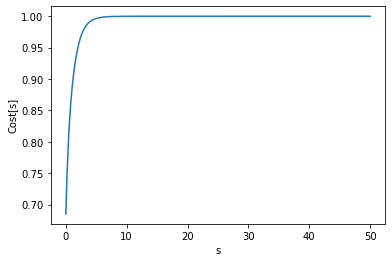

In [ ]:
network121 = randomNetwork([1,2,1], 10)
plotlist121 = qnnTraining(network121[0], network121[1], network121[2], 1, 0.1, 500)[0]

for i in range(len(plotlist121[1])):
    if plotlist121[1][i] >= 0.95:
        print("Exceeds cost of 0.95 at training step "+str(i))
        break

plt.plot(plotlist121[0], plotlist121[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

### Training a 2-3-2 network

Trained 500 rounds for a [2, 3, 2] network and 10 training pairs in 99.63 seconds
Exceeds cost of 0.95 at training step 54


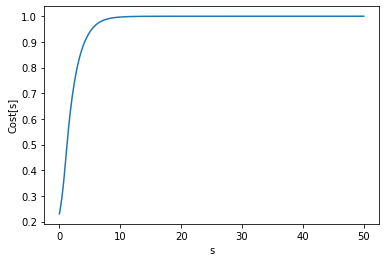

In [ ]:
network232 = randomNetwork([2,3,2], 10)
plotlist232 = qnnTraining(network232[0], network232[1], network232[2], 1, 0.1, 500)[0]

for i in range(len(plotlist232[1])):
    if plotlist232[1][i] >= 0.95:
        print("Exceeds cost of 0.95 at training step "+str(i))
        break

plt.plot(plotlist232[0], plotlist232[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

### Varying $\lambda$ for a 2-2 network

Trained 200 rounds for a [2, 2] network and 10 training pairs in 12.32 seconds
Trained 200 rounds for a [2, 2] network and 10 training pairs in 13.62 seconds
Trained 200 rounds for a [2, 2] network and 10 training pairs in 13.06 seconds


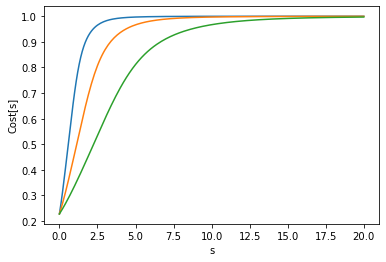

In [ ]:
network22 = randomNetwork([2,2], 10)

plotlistHalf = qnnTraining(network22[0], network22[1], network22[2], 0.5, 0.1, 200)[0]
plotlistOne = qnnTraining(network22[0], network22[1], network22[2], 1, 0.1, 200)[0]
plotlistTwo = qnnTraining(network22[0], network22[1], network22[2], 2, 0.1, 200)[0]


plt.plot(plotlistHalf[0],plotlistHalf[1])
plt.plot(plotlistOne[0], plotlistOne[1])
plt.plot(plotlistTwo[0], plotlistTwo[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

## Big networks

### Training a 2-3-3-2 network

In training round 0
In training round 250
In training round 500
In training round 750
Trained 1000 rounds for a [2, 3, 3, 2] network and 5 training pairs in 241.57 seconds


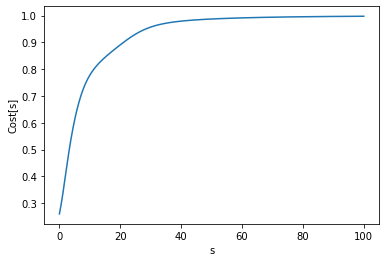

In [ ]:
#mathematica
    #run 1: 249,6s
#python
    #run 1: 148,7s
    #run 2: 142,8s

network2332 = randomNetwork([2,3,3,2], 5)
plotlist2332 = qnnTraining(network2332[0], network2332[1], network2332[2], 4, 0.1, 1000, 250)[0]

plt.plot(plotlist2332[0], plotlist2332[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

### Training a 2-3-4-3-2 network #1

(Small set of training data, high number of rounds.)

In training round 0
In training round 250
In training round 500
In training round 750
Trained 1000 rounds for a [2, 3, 4, 3, 2] network and 5 training pairs in 895.04 seconds


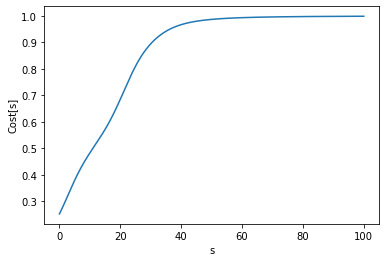

In [ ]:
#mathematica
    #run 1: 2324s = 38,7 min
    #run 2: 1501s = 25,0 min
#python
    #run 1: 545s = 9,1 min
    #run 2: 553s = 9,2 min

network23432 = randomNetwork([2,3,4,3,2], 5)
plotlist23432= qnnTraining(network23432[0], network23432[1], network23432[2], 4, 0.1, 1000, 250)[0]

plt.plot(plotlist23432[0], plotlist23432[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

### Training a 2-3-4-3-2 network #2

(Big set of training data, small number of rounds.)

In training round 0
In training round 50
In training round 100
In training round 150
In training round 200
In training round 250
Trained 300 rounds for a [2, 3, 4, 3, 2] network and 100 training pairs in 4833.49 seconds


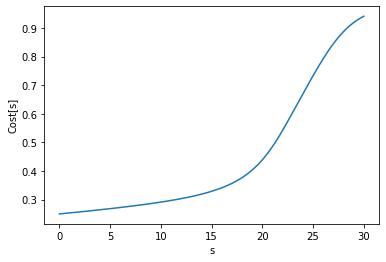

In [ ]:
#mathematica
    #(430s for 50/50)
    #run 1: 4762s = 79 min
#python
    #(266s for 50/50)
    #run 1: 3328s = 55 min

network23432Two = randomNetwork([2,3,4,3,2], 100)
plotlist23432Two= qnnTraining(network23432Two[0], network23432Two[1], network23432Two[2], 4, 0.1, 300, 50)[0]

plt.plot(plotlist23432Two[0], plotlist23432Two[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

## Generalization

### Subset training for a 2-2 network | D = 4

n=1, i=0
Trained 1000 rounds for a [2, 2] network and 1 training pairs in 14.72 seconds
Trained 1000 rounds for a [2, 2] network and 1 training pairs in 11.71 seconds
Trained 1000 rounds for a [2, 2] network and 1 training pairs in 9.94 seconds
Trained 1000 rounds for a [2, 2] network and 1 training pairs in 10.21 seconds
Trained 1000 rounds for a [2, 2] network and 1 training pairs in 9.79 seconds
Trained 1000 rounds for a [2, 2] network and 1 training pairs in 10.17 seconds
Trained 1000 rounds for a [2, 2] network and 1 training pairs in 9.72 seconds
Trained 1000 rounds for a [2, 2] network and 1 training pairs in 9.22 seconds
Trained 1000 rounds for a [2, 2] network and 1 training pairs in 9.56 seconds
Trained 1000 rounds for a [2, 2] network and 1 training pairs in 11.55 seconds
Trained 1000 rounds for a [2, 2] network and 1 training pairs in 8.87 seconds
Trained 1000 rounds for a [2, 2] network and 1 training pairs in 11.31 seconds
Trained 1000 rounds for a [2, 2] network and 1 tr

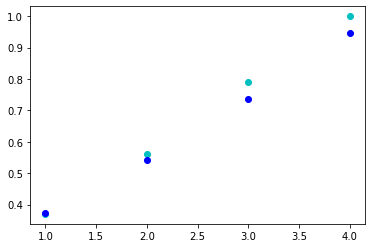

In [ ]:
#mathematica
    #run 1: 645s = 10,8 min
#python
    #run 1: 884s = 14,7 min
    #run 2: ~940s = ~15,7 min

subsetNetwork22 = randomNetwork([2,2], 10)

start = time() #Optional

pointsX = list(range(1,5))
pointsBoundRand = [boundRand(4, 10, n) for n in pointsX]
pointsAverageCost = [subsetTrainingAvg(subsetNetwork22[0], subsetNetwork22[1], subsetNetwork22[2], 1.5, 0.1, 1000, 20, n, alertIt=20) for n in pointsX]

print(time() - start) #Optional

plt.plot(pointsX, pointsBoundRand, 'co')
plt.plot(pointsX, pointsAverageCost, 'bo')
plt.show()

### Subset training for a 3-3-3 network | D = 8

In [ ]:
#mathematica
    #run 1: 45744s > 12h

## Robustness to noisy data

In [ ]:
noiseTrainingData = randomTrainingData(randomQubitUnitary(2), 100)
noiseNoisyData = [[randomQubitState(2), randomQubitState(2)] for i in range(100)]

### Noisy data for a 2-2 network

Trained 300 rounds for a [2, 2] network and 100 training pairs in 165.34 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 163.93 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 166.27 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 190.67 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 230.14 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 191.08 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 179.44 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 184.26 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 240.92 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 226.44 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 185.44 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 198.04 seconds
Trained 300 rounds for a [2,

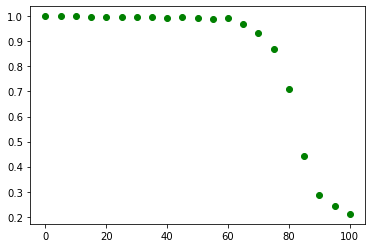

In [ ]:
#mathematica
    #run 1: 1659s = 27,7 min
#python
    #run 1: 2284s = 38,1 min

start = time() #Optional

noiseNetwork22 = randomNetwork([2,2], 0)
noisePlotlist22 = noisyDataTraining(noiseNetwork22[0], noiseNetwork22[1], noiseTrainingData.copy(), noiseNoisyData.copy(), 1, 0.1, 300, 100, 5)

print(time() - start) #Optional

plt.plot(noisePlotlist22[0], noisePlotlist22[1], 'go')
plt.show()

### Noisy data for a 2-3-2 network

Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 544.03 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 537.44 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 538.77 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 539.67 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 570.2 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 939.64 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 1095.14 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 1104.58 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 1140.37 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 1094.75 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 1130.88 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 108

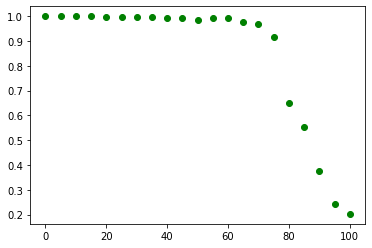

In [ ]:
#mathematica
    #run 1: 6256s = 104 min
#python
    #run 1: 7649s = 127 min

start = time() #Optional

noiseNetwork232 = randomNetwork([2,3,2], 0)
noisePlotlist232 = noisyDataTraining(noiseNetwork232[0], noiseNetwork232[1], noiseTrainingData.copy(), noiseNoisyData.copy(), 1, 0.1, 300, 100, 5)

print(time() - start) #Optional

plt.plot(noisePlotlist232[0], noisePlotlist232[1], 'go')
plt.show()